In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from lane_detection import LaneDetection
from lane import LeftLane, RightLane

filenames = [filename for filename in glob.glob('./project_video-frames/*.jpg')
         if -1 == filename.find('proc')]

lane_algo = LaneDetection()
ll = lane_algo.left_lane
rl = lane_algo.right_lane

print('Algorithm Initialized')

Algorithm Initialized


## Test File

Testing process on:  ./project_video-frames/0000.jpg


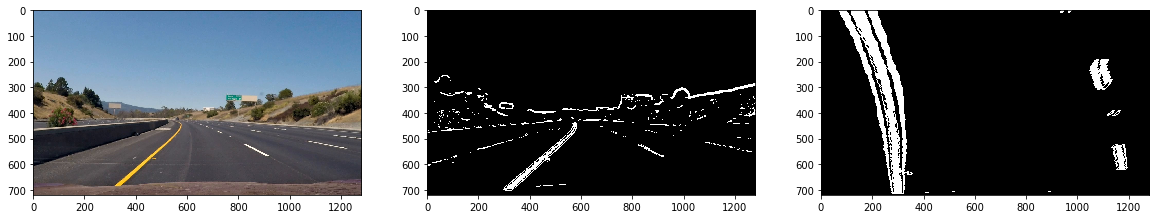

In [2]:
#testfile = './project_video-frames/1038.jpg'
#testfile = './project_video-frames/0989.jpg'
testfile = './project_video-frames/0000.jpg'

print('Testing process on: ', testfile)

def load_test_image():
    img = mpimg.imread(testfile)
    return img

img = load_test_image()
binary_warped = lane_algo.get_warped_image(img)
binary_img = lane_algo.binary_img

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,10))

ax1.imshow(img)
ax2.imshow(binary_img, cmap='gray')
ax3.imshow(binary_warped, cmap='gray')

plt.show()

# Sliding Window

## Identify Lane Start

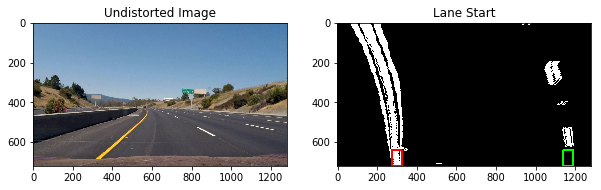

In [3]:
img = load_test_image()
binary_warped = lane_algo.get_warped_image(img)

l_center, r_center = lane_algo.find_bottom_left_right(binary_warped)
window_width = lane_algo.left_lane.window_width
window_height = lane_algo.left_lane.window_height

final_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

def draw_box(center, color):
    lt = center - window_width // 2, binary_warped.shape[0] - window_height
    rb = center + window_width // 2, binary_warped.shape[0]
    cv2.rectangle(final_img, lt, rb, color, 10)

draw_box(l_center, (255, 0, 0))
draw_box(r_center, (0, 255, 0))

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(img)
ax1.set_title('Undistorted Image')
ax2.imshow(final_img, cmap='gray')
ax2.set_title('Lane Start')

plt.show()

## Actual Windows Found

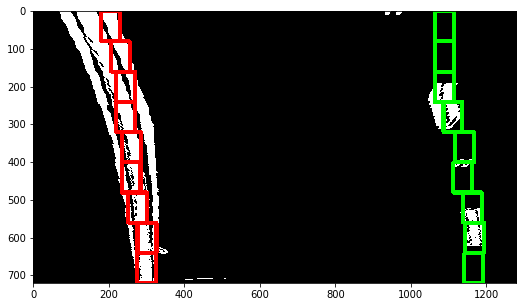

In [4]:
final_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

l_centers = ll.get_windows_x_y()
r_centers = rl.get_windows_x_y()

def draw_boxes(centers, color):
    for (lt, rb) in centers:
        cv2.rectangle(final_img, lt, rb, color, 10)

draw_boxes(l_centers, (255, 0, 0))
draw_boxes(r_centers, (0, 255, 0))

f, ax1 = plt.subplots(1,1, figsize=(10,5))
ax1.imshow(final_img)

plt.show()

## Pixels Chosen For Each Sliding Window

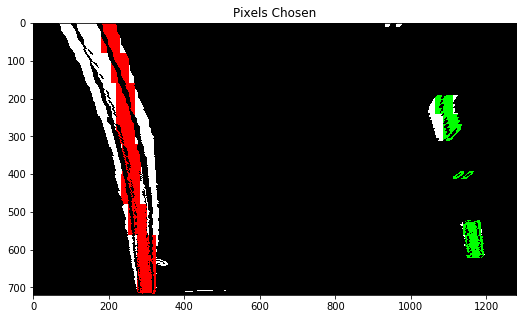

In [7]:
ll.find_using_sliding_window()
rl.find_using_sliding_window()

final_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

final_img[ll.chosen_y, ll.chosen_x] = [255, 0, 0]
final_img[rl.chosen_y, rl.chosen_x] = [0, 255, 0]

f, ax1 = plt.subplots(1,1, figsize=(10,5))
ax1.imshow(final_img, cmap='gray')
ax1.set_title('Pixels Chosen')

plt.show()


## Left and Right Polynomial

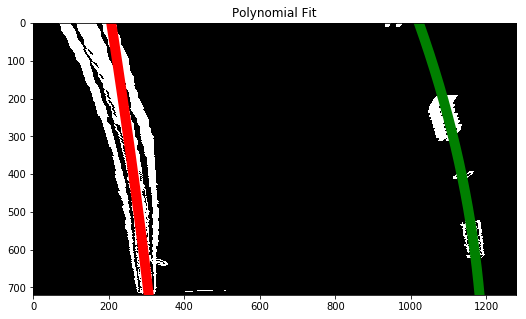

In [13]:
ll.find_using_sliding_window()
rl.find_using_sliding_window()

f, ax1 = plt.subplots(1,1, figsize=(10,5))

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Polynomial Fit')
ax1.plot(ll.current_fitx, ll.current_fity, color='red', linewidth = 10)
ax1.plot(rl.current_fitx, rl.current_fity, color='green', linewidth = 10)

plt.show()

## Curvature

In [ ]:
left_curv = ll.calculate_curvature()
right_curv = rl.calculate_curvature()
avg_curv = np.average(np.array([left_curv, right_curv]))

print('Left Curvature: ', left_curv)
print('Right Curvature: ', right_curv)
print('Averaged Curvature: ', avg_curv)

## Final Image

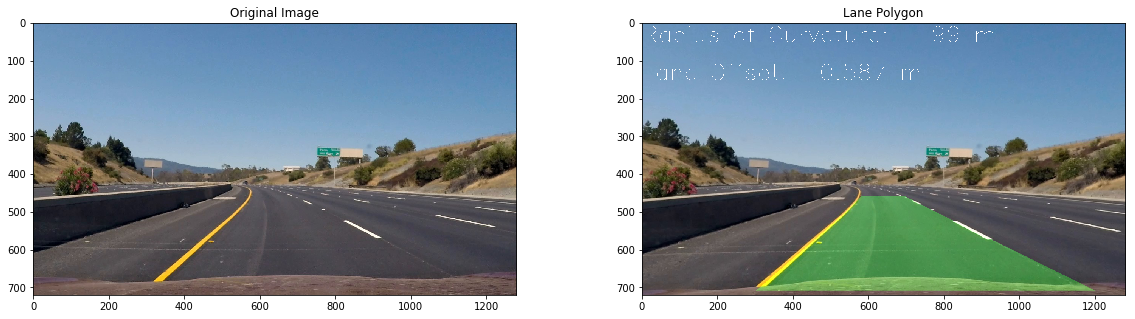

In [16]:
img = load_test_image()

final_img = lane_algo.process_image(img)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))

ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(final_img, cmap='gray')
ax2.set_title('Lane Polygon')

plt.show()

## Test Lane Offset Calculation

In [ ]:
lane_algo = LaneDetection()
img = mpimg.imread('./test_images/straight_lines1.jpg')

img_lanes = lane_algo.process_image(img)

plt.figure(figsize=(20,10))
plt.imshow(img_lanes)
plt.show()

mpimg.imsave('straight_lines1.jpg', img_lanes, format='jpeg')

## Test on multiple frames

In [ ]:
from lane_detection import LaneDetection
from moviepy.editor import VideoFileClip
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

frames = [filename for filename in glob.glob('./project_video-frames/*.jpg')
     if -1 == filename.find('proc')]

lane_algo = LaneDetection()

def load_image(filename):
    img = mpimg.imread(filename)
    if img.shape[2] > 3:
        return img[:,:,:3]
    else:
        return img

def get_random(samples):
    return np.random.choice(len(frames), samples, replace=False)
    
def process_folder():
    indices = get_random(10)
    filenames = [frames[i] for i in indices]
    print(filenames)
    
    for filename in filenames:
        lane_algo = LaneDetection()
        
        print('Processing filename:', filename)
        
        fileparts = os.path.splitext(filename)
        output = fileparts[0] + '-proc' + fileparts[1]

        img = load_image(filename)

        final_img = lane_algo.process_image(img)
        undistort_img = lane_algo.undistort_img

        mpimg.imsave(output, final_img, format='jpeg')

        f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

        ax1.imshow(undistort_img)
        ax1.set_title(filename)
        ax2.imshow(final_img)
        ax2.set_title('Lane')
        plt.show()


def process_image(img):
    return lane_algo.process_image(img)
    
def mark_lanes_video(video_filename):
    clip = VideoFileClip(video_filename)
    video_with_lanes = clip.fl_image(process_image)
    
    output = os.path.splitext(video_filename)
    output_file = output[0] + "-Lanes" + output[1]
    video_with_lanes.write_videofile(output_file, audio=False)
    
    print('File saved to:', output_file)
    
process_folder()

In [ ]:
mark_lanes_video("project_video.mp4")